In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import xgboost as xgb
from sklearn import model_selection, preprocessing
color = sns.color_palette()
%matplotlib inline

def num2log(arr):
    return np.log(arr + 1)
# result retransform
def log2num(arr):
    return np.exp(arr) - 1
# treat date
def trans_date(arr): 
    return datetime.datetime.strptime(arr, '%Y-%m-%d').date()

data = pd.read_csv('C:/Users/JP/Documents/School/Practicum/Github/Practicum/data/dataset.csv')

df = pd.DataFrame(data)
df['Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')
df = df.set_index('Date')
df=df[df.index>'2017-05-30']
df.head()

,ETHOpen,ETHHigh,ETHLow,TBondsOpenValue,IndexFutures,InflationRateValue,UnemploymentValue,FedFundRateValue,GDP,SandPValue
Date,,,,,,,,,,
2017-05-31,228.58,233.92,214.05,154.68750,97.135,2.200,4.3,0.83,18569.1,2411.0
2017-05-31,228.58,233.92,214.05,154.68750,97.135,1.872,4.3,0.83,18569.1,2411.0
2017-06-01,228.64,235.52,208.00,154.96875,96.740,1.872,4.3,0.91,18569.1,2413.1
2017-06-01,228.64,235.52,208.00,154.96875,96.740,1.872,4.4,0.91,18569.1,2413.1
2017-06-02,220.70,227.71,216.94,154.90625,96.960,1.872,4.4,0.91,18569.1,2429.6


In [138]:
train_df = df[df.index<'2017-09-01']

train_df.head()

,ETHOpen,ETHHigh,ETHLow,TBondsOpenValue,IndexFutures,InflationRateValue,UnemploymentValue,FedFundRateValue,GDP,SandPValue,Date
Date,,,,,,,,,,,
2017-05-31,228.58,233.92,214.05,154.68750,97.135,2.200,4.3,0.83,18569.1,2411.0,2017-05-31
2017-05-31,228.58,233.92,214.05,154.68750,97.135,1.872,4.3,0.83,18569.1,2411.0,2017-05-31
2017-06-01,228.64,235.52,208.00,154.96875,96.740,1.872,4.3,0.91,18569.1,2413.1,2017-06-01
2017-06-01,228.64,235.52,208.00,154.96875,96.740,1.872,4.4,0.91,18569.1,2413.1,2017-06-01
2017-06-02,220.70,227.71,216.94,154.90625,96.960,1.872,4.4,0.91,18569.1,2429.6,2017-06-02


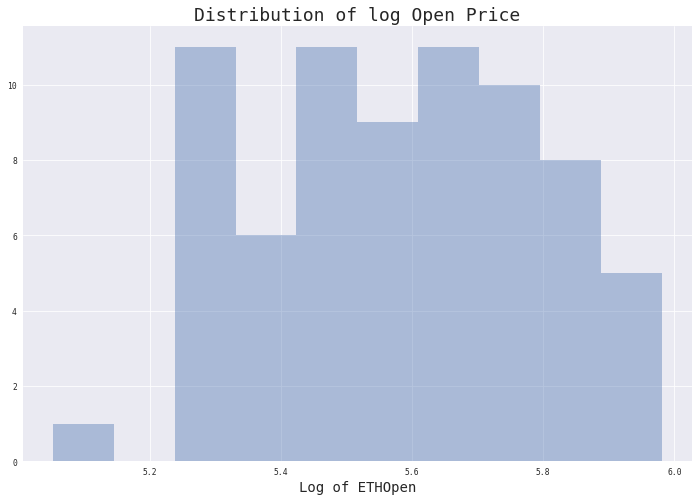

In [139]:
plt.figure(figsize=(12,8))
sns.distplot(num2log(train_df.ETHOpen.values), bins=10, kde=False)
plt.xlabel('Log of ETHOpen', fontsize=14)
plt.title('Distribution of log Open Price', fontsize = 18)
plt.show()

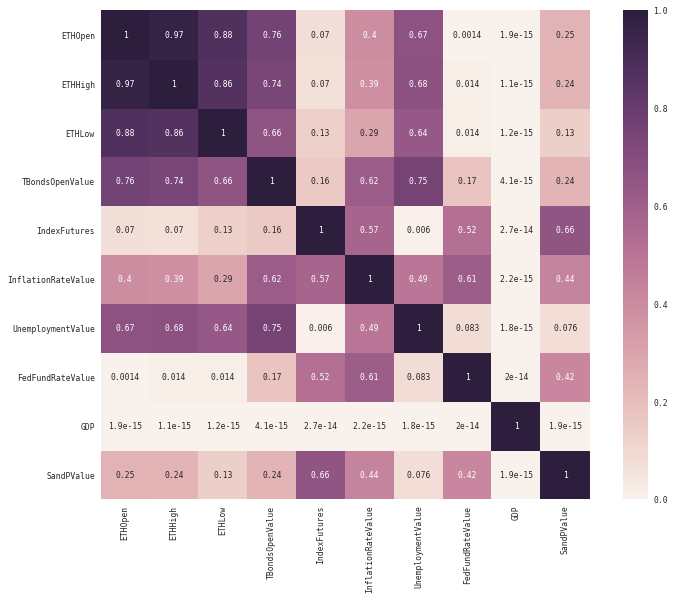

In [140]:
corrmat = train_df.corr(method='pearson')
corrmat = np.abs(corrmat)
sns.set(context="paper", font="monospace")
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1,annot=True, square=True, xticklabels = True, yticklabels = True, 
            annot_kws={'size': 8})

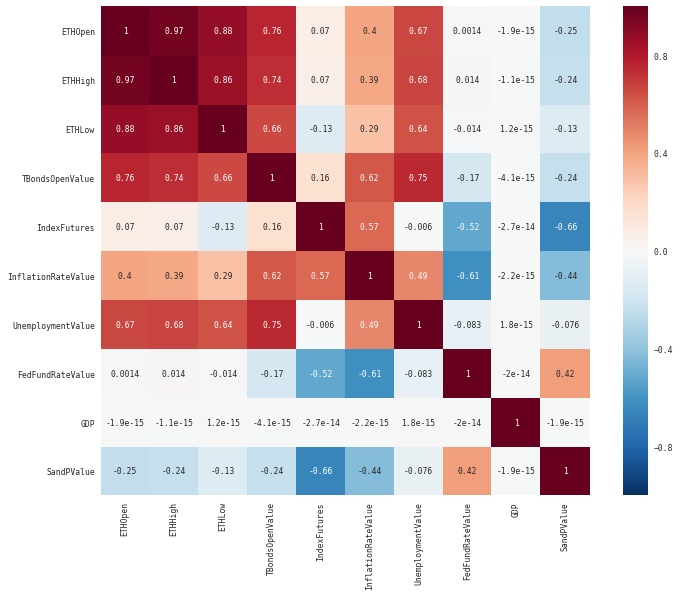

In [141]:
corrmat = train_df.corr(method='pearson')

sns.set(context="paper", font="monospace")
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1,vmin=-1,annot=True, square=True, xticklabels = True, yticklabels = True, 
            annot_kws={'size': 8})

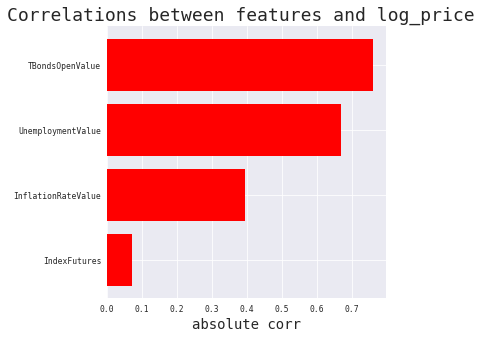

In [142]:
remain_num = 10
#train_df['logETHOpen'] = num2log(train_df.ETHOpen.values)
corr_target = corrmat['ETHOpen'].reset_index()[3:]
corr_target.columns = ['feature','abs_corr']
corr_target = corr_target.sort_values(by = 'abs_corr', ascending = True)[:remain_num].loc[corr_target['abs_corr'] >0.01]
ind = np.arange(corr_target.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(5,5))
rects = ax.barh(ind, corr_target.abs_corr.values, color='r')
ax.set_yticks(ind)
ax.set_yticklabels(corr_target.feature.values, rotation='horizontal')
ax.set_xlabel("absolute corr", fontsize = 14)
ax.set_title("Correlations between features and log_price ", fontsize = 18)
plt.show()


In [143]:
# X(t+1) = b0 + b1*X(t-1) + b2*X(t-2)
df.tail()


,ETHOpen,ETHHigh,ETHLow,TBondsOpenValue,IndexFutures,InflationRateValue,UnemploymentValue,FedFundRateValue,GDP,SandPValue,Date
Date,,,,,,,,,,,
2017-09-15,223.14,267.70,200.75,156.62500,91.775,1.939,4.4,1.16,18569.1,NaN,2017-09-15
2017-09-18,258.40,300.69,258.36,156.21875,91.435,1.939,4.4,1.16,18569.1,2498.2,2017-09-18
2017-09-19,297.53,299.91,275.94,155.81250,91.505,1.939,4.4,1.16,18569.1,2502.3,2017-09-19
2017-09-20,283.00,293.74,277.72,155.46875,91.275,1.939,4.4,1.16,18569.1,2502.3,2017-09-20
2017-09-21,283.56,287.13,252.22,153.90625,92.130,1.939,4.4,1.16,18569.1,2505.0,2017-09-21


In [144]:
import json
import requests
import pandas as pd

from pandas.io.json import json_normalize



response = requests.get("https://min-api.cryptocompare.com/data/histoday?fsym=ETH&tsym=USD&allData=TRUE")


data = json.loads(response.text)
data2 = json_normalize(data)
json_data = data['Data']
df2=pd.DataFrame(data['Data'])
df2['time'] = pd.to_datetime(df2['time'],unit='s')
df2['Date'] = pd.to_datetime(df2['time'],unit='s')
BTC = df2[['Date','open']]
BTC['BTCOpen']=BTC['open']
BTC=BTC[['Date','BTCOpen']]
BTC.tail()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Date,BTCOpen
785,2017-09-30,292.58
786,2017-10-01,302.77
787,2017-10-02,303.95
788,2017-10-03,296.81
789,2017-10-04,291.81


In [145]:
df=df[df.index>'2017-05-30']
df['Date'] = df.index.values
dataset = pd.merge(df, BTC, on='Date')
dataset.tail()

,ETHOpen,ETHHigh,ETHLow,TBondsOpenValue,IndexFutures,InflationRateValue,UnemploymentValue,FedFundRateValue,GDP,SandPValue,Date,BTCOpen
81,223.14,267.70,200.75,156.62500,91.775,1.939,4.4,1.16,18569.1,NaN,2017-09-15,223.14
82,258.40,300.69,258.36,156.21875,91.435,1.939,4.4,1.16,18569.1,2498.2,2017-09-18,258.40
83,297.53,299.91,275.94,155.81250,91.505,1.939,4.4,1.16,18569.1,2502.3,2017-09-19,297.53
84,283.00,293.74,277.72,155.46875,91.275,1.939,4.4,1.16,18569.1,2502.3,2017-09-20,283.00
85,283.56,287.13,252.22,153.90625,92.130,1.939,4.4,1.16,18569.1,2505.0,2017-09-21,283.56


In [146]:
dataset['ETHOpenTM1'] = dataset['ETHOpen'].shift(-1)
dataset['ETHOpenTM2'] = dataset['ETHOpen'].shift(-2)
dataset['ETHOpenTM3'] = dataset['ETHOpen'].shift(-3)
dataset['ETHOpenTM4'] = dataset['ETHOpen'].shift(-4)
dataset['ETHOpenTM5'] = dataset['ETHOpen'].shift(-5)
dataset['ETHOpenTM6'] = dataset['ETHOpen'].shift(-6)
dataset['ETHOpenTM7'] = dataset['ETHOpen'].shift(-7)
dataset['BTCOpenTM1'] = dataset['BTCOpen'].shift(-1)
dataset['BTCOpenTM2'] = dataset['BTCOpen'].shift(-2)
dataset['BTCOpenTM3'] = dataset['BTCOpen'].shift(-3)
dataset['BTCOpenTM4'] = dataset['BTCOpen'].shift(-4)
dataset['BTCOpenTM5'] = dataset['BTCOpen'].shift(-5)
dataset['BTCOpenTM6'] = dataset['BTCOpen'].shift(-6)
dataset['BTCOpenTM7'] = dataset['BTCOpen'].shift(-7)
dataset.head()

,ETHOpen,ETHHigh,ETHLow,TBondsOpenValue,IndexFutures,InflationRateValue,UnemploymentValue,FedFundRateValue,GDP,SandPValue,...,ETHOpenTM5,ETHOpenTM6,ETHOpenTM7,BTCOpenTM1,BTCOpenTM2,BTCOpenTM3,BTCOpenTM4,BTCOpenTM5,BTCOpenTM6,BTCOpenTM7
0,228.58,233.92,214.05,154.68750,97.135,2.200,4.3,0.83,18569.1,2411.0,...,244.96,247.75,264.26,228.58,228.64,228.64,220.70,244.96,247.75,264.26
1,228.58,233.92,214.05,154.68750,97.135,1.872,4.3,0.83,18569.1,2411.0,...,247.75,264.26,255.77,228.64,228.64,220.70,244.96,247.75,264.26,255.77
2,228.64,235.52,208.00,154.96875,96.740,1.872,4.3,0.91,18569.1,2413.1,...,264.26,255.77,259.41,228.64,220.70,244.96,247.75,264.26,255.77,259.41
3,228.64,235.52,208.00,154.96875,96.740,1.872,4.4,0.91,18569.1,2413.1,...,255.77,259.41,339.68,220.70,244.96,247.75,264.26,255.77,259.41,339.68
4,220.70,227.71,216.94,154.90625,96.960,1.872,4.4,0.91,18569.1,2429.6,...,259.41,339.68,394.66,244.96,247.75,264.26,255.77,259.41,339.68,394.66


In [151]:
dataset.to_csv('C:/Users/JP/Documents/School/Practicum/Github/Practicum/data/dataset2.csv',index=False)


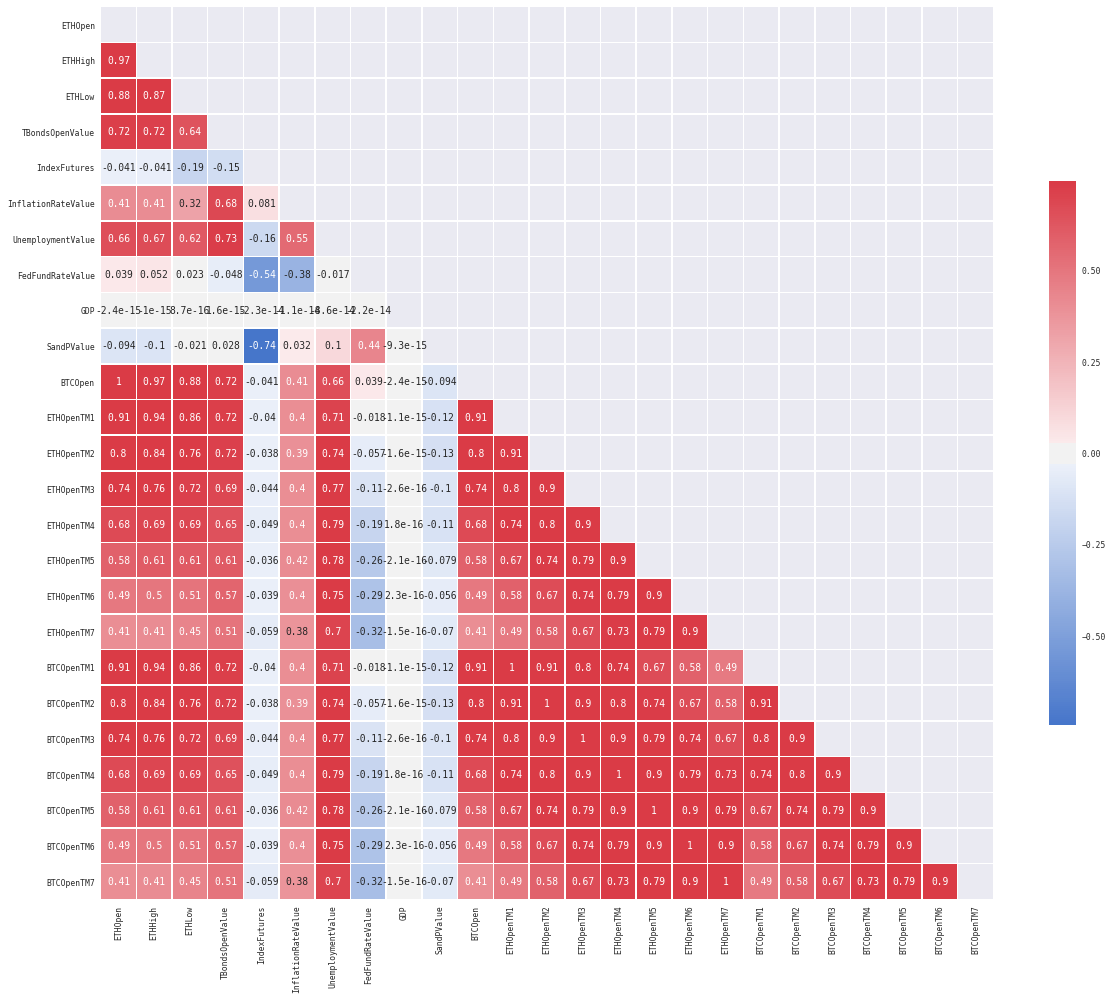

In [152]:
corr = dataset.corr(method='pearson')
#corrmat = np.abs(corrmat)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True



cmap = sns.diverging_palette(255, 10, as_cmap=True)

f, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,xticklabels = True, yticklabels = True, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

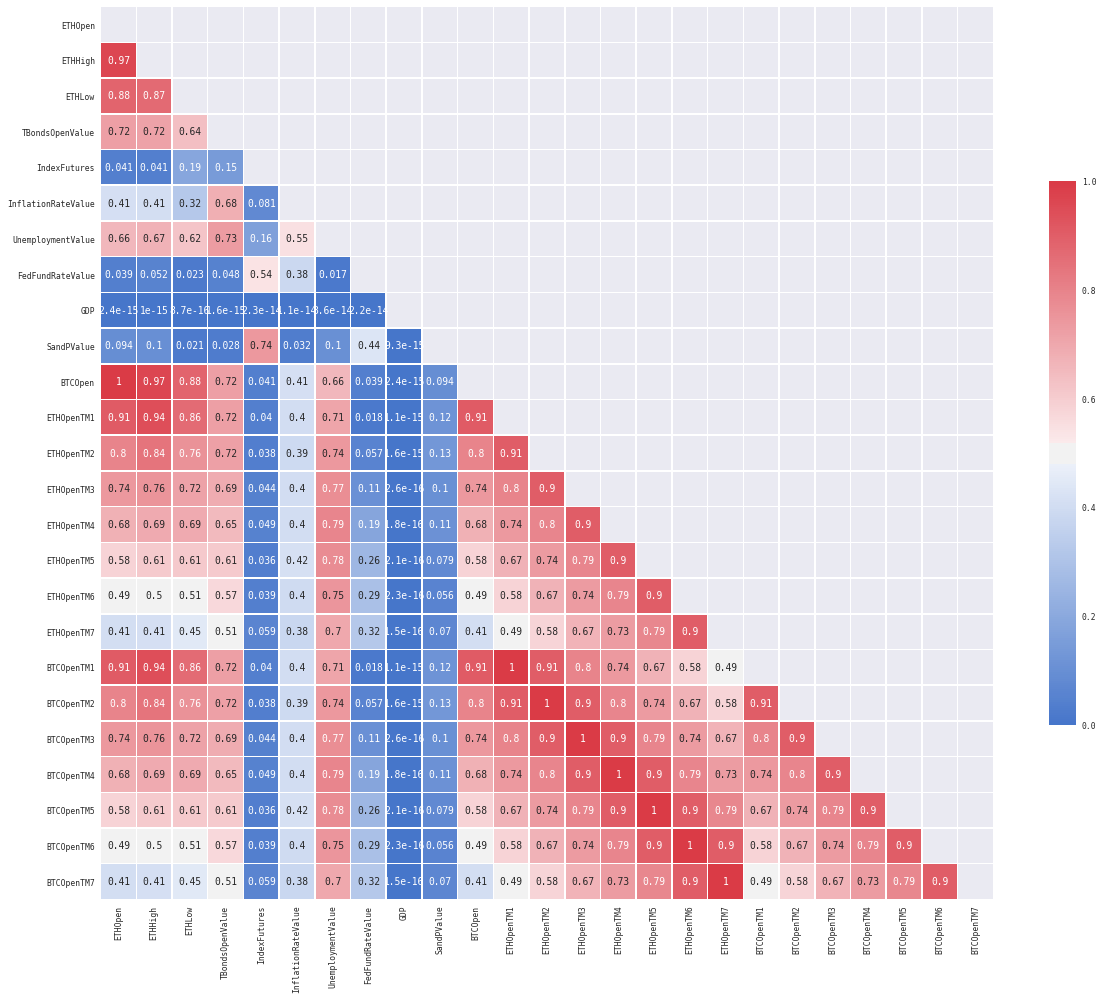

In [148]:
corr = dataset.corr(method='pearson')
corr = np.abs(corr)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


f, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=.5,xticklabels = True, yticklabels = True, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

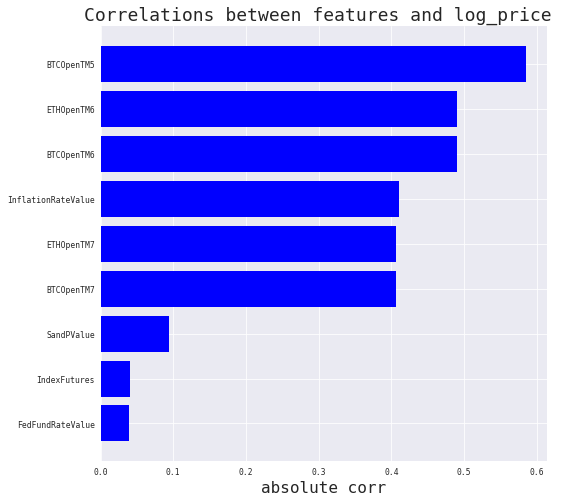

In [149]:
corr_target = corr['ETHOpen'].reset_index()[3:]
corr_target.columns = ['feature','abs_corr']
corr_target = corr_target.sort_values(by = 'abs_corr', ascending = True)[:remain_num].loc[corr_target['abs_corr'] >0.01]
ind = np.arange(corr_target.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(8,8))
rects = ax.barh(ind, corr_target.abs_corr.values, color='b')
ax.set_yticks(ind)
ax.set_yticklabels(corr_target.feature.values, rotation='horizontal')
ax.set_xlabel("absolute corr", fontsize = 16)
ax.set_title("Correlations between features and log_price ", fontsize = 18)
plt.show()